In [1]:
import polars as pl
import polars.selectors as cs
import soccerdata as sd
import matplotlib.pyplot as plt
import sklearn as skl
import pandas as ps
import numpy as np
import pyarrow
import seaborn as sb

[12/18/25 14:53:21] INFO     No custom team name replacements found. You can configure these in       ]8;id=116737;file://c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\soccerdata\_config.py\_config.py]8;;\:]8;id=835650;file://c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\soccerdata\_config.py#91\91]8;;\
                             C:\Users\User\soccerdata\config\teamname_replacements.json.                           

                    INFO     Custom league dict loaded from                                          ]8;id=139147;file://c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\soccerdata\_config.py\_config.py]8;;\:]8;id=664052;file://c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\soccerdata\_config.py#195\195]8;;\
                             C:\Users\User\soccerdata\config\league_dict.json.                                     

In [2]:
fbref = sd.FBref(seasons=2025)
print(fbref.__doc__)

[12/18/25 14:53:22] INFO     Saving cached data to C:\Users\User\soccerdata\data\FBref               ]8;id=970849;file://c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=479507;file://c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\soccerdata\_common.py#263\263]8;;\

Provides pd.DataFrames from data at http://fbref.com.

    Data will be downloaded as necessary and cached locally in
    ``~/soccerdata/data/FBref``.

    Parameters
    ----------
    leagues : string or iterable, optional
        IDs of leagues to include. For efficiently reading data from the Top-5
        European leagues, use "Big 5 European Leagues Combined".
    seasons : string, int or list, optional
        Seasons to include. Supports multiple formats.
        Examples: '16-17'; 2016; '2016-17'; [14, 15, 16]
    proxy : 'tor' or dict or list(dict) or callable, optional
        Use a proxy to hide your IP address. Valid options are:
            - "tor": Uses the Tor network. Tor should be running in
              the background on port 9050.
            - dict: A dictionary with the proxy to use. The dict should be
              a mapping of supported protocols to proxy addresses. For example::

                  {
                      'http': 'http://10.10.1.10:3128',
     

In [3]:
player_season_stats = fbref.read_player_season_stats(stat_type="standard")
player_season_stats.head()


                    WARNING  c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-package ]8;id=481109;file://c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=964019;file://c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py#112\112]8;;\
                             s\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                   
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

                    WARNING  c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-package ]8;id=746340;file://c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=121862;file://c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py#112\112]8;;\
                             s\soccerdata\_common.py:145: UserWarning: Season id "2021" is                         
                             ambiguous: interpreting as "20-21"                                                    
                               warnings.warn(msg, stacklevel=1)                                                    
                                                                                                                   

[12/18/25 14:53:25] WARNING  c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-package ]8;id=779328;file://c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=610760;file://c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py#112\112]8;;\
                             s\soccerdata\fbref.py:1220: UserWarning: Different columns found for                  
                             [['ENG-Premier League' '2526']] and [['TUR-Süper Lig' '2526']].                       
                                                                                                                   
                             The following columns are missing in [['ENG-Premier League' '2526']]:                 
                             ('Expected', 'npxG'), ('Expected', 'npxG+xAG'), ('Expected', 'xAG'),                  
                             ('Expected', 'xG'), ('Per 90 Minutes', 'npxG'), ('Per 90 Minutes',                    
                             'npxG+xAG'), ('Per 90 Minutes', 'xAG'), ('Per 90 Minutes', 'xG'),                     
                             ('Per 90 Minutes', 'xG+xAG'), ('Progression', 'PrgC'), ('Progression',                
                             'PrgP'), ('Progression', 'PrgR').                                                     
                                                                                                                   
                             The following columns are missing in [['TUR-Süper Lig' '2526']]: .                    
                                                                                                                   
                             The columns of the dataframe with the most columns will be used.                      
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-package ]8;id=534295;file://c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=928456;file://c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py#112\112]8;;\
                             s\soccerdata\fbref.py:1273: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               return pd.concat(dfs)                                                               
                                                                                                                   

nation    pos  \
                                                                                
league               season team            player                              
ENG-EFL Championship 2526   Birmingham City Alex Cochrane          ENG     DF   
                                            Alfons Sampsted        ISL  DF,MF   
                                            Bright Osayi-Samuel    NGA     DF   
                                            Christoph Klarer       AUT     DF   
                                            Demarai Gray           JAM  FW,MF   

                                                                    age  born  \
                                                                                
league               season team            player                              
ENG-EFL Championship 2526   Birmingham City Alex Cochrane        25-241  2000   
                                            Alfons Sampsted      27-256  1998   
                                            Bright Osayi-Samuel  27-352  1997   
                                            Christoph Klarer     25-187  2000   
                                            Demarai Gray         29-173  1996   

                                                                Playing Time  \
                                                                          MP   
league               season team            player                             
ENG-EFL Championship 2526   Birmingham City Alex Cochrane                 18   
                                            Alfons Sampsted                2   
                                            Bright Osayi-Samuel           14   
                                            Christoph Klarer              21   
                                            Demarai Gray                  21   

                                                                              \
                                                                Starts   Min   
league               season team            player                             
ENG-EFL Championship 2526   Birmingham City Alex Cochrane           17  1466   
                                            Alfons Sampsted          0    24   
                                            Bright Osayi-Samuel     10   784   
                                            Christoph Klarer        21  1890   
                                            Demarai Gray            19  1577   

                                                                       \
                                                                  90s   
league               season team            player                      
ENG-EFL Championship 2526   Birmingham City Alex Cochrane        16.3   
                                            Alfons Sampsted       0.3   
                                            Bright Osayi-Samuel   8.7   
                                            Christoph Klarer     21.0   
                                            Demarai Gray         17.5   

                                                                Performance  \
                                                                        Gls   
league               season team            player                            
ENG-EFL Championship 2526   Birmingham City Alex Cochrane                 1   
                                            Alfons Sampsted               0   
                                            Bright Osayi-Samuel           0   
                                            Christoph Klarer              2   
                                            Demarai Gray                  5   

                                                                     ...  \
                                                                Ast  ...   
league               season team            player                   ...   
ENG-EFL Championship 2526   Birmingham

In [4]:
df = fbref.read_player_season_stats(stat_type='defense')

# Access only the Per 90 columns
print(df.columns)

                    WARNING  c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-package ]8;id=660946;file://c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=101318;file://c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py#112\112]8;;\
                             s\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                   
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

                    WARNING  c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-package ]8;id=779650;file://c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=30370;file://c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py#112\112]8;;\
                             s\soccerdata\_common.py:145: UserWarning: Season id "2021" is                         
                             ambiguous: interpreting as "20-21"                                                    
                               warnings.warn(msg, stacklevel=1)                                                    
                                                                                                                   

MultiIndex([(    'nation',        ''),
            (       'pos',        ''),
            (       'age',        ''),
            (      'born',        ''),
            (       '90s',        ''),
            (   'Tackles',     'Tkl'),
            (   'Tackles',    'TklW'),
            (   'Tackles', 'Def 3rd'),
            (   'Tackles', 'Mid 3rd'),
            (   'Tackles', 'Att 3rd'),
            ('Challenges',     'Tkl'),
            ('Challenges',     'Att'),
            ('Challenges',    'Tkl%'),
            ('Challenges',    'Lost'),
            (    'Blocks',  'Blocks'),
            (    'Blocks',      'Sh'),
            (    'Blocks',    'Pass'),
            (       'Int',        ''),
            (   'Tkl+Int',        ''),
            (       'Clr',        ''),
            (       'Err',        '')],
           )


In [5]:
print(player_season_stats.columns)

MultiIndex([(        'nation',         ''),
            (           'pos',         ''),
            (           'age',         ''),
            (          'born',         ''),
            (  'Playing Time',       'MP'),
            (  'Playing Time',   'Starts'),
            (  'Playing Time',      'Min'),
            (  'Playing Time',      '90s'),
            (   'Performance',      'Gls'),
            (   'Performance',      'Ast'),
            (   'Performance',      'G+A'),
            (   'Performance',     'G-PK'),
            (   'Performance',       'PK'),
            (   'Performance',    'PKatt'),
            (   'Performance',     'CrdY'),
            (   'Performance',     'CrdR'),
            (      'Expected',       'xG'),
            (      'Expected',     'npxG'),
            (      'Expected',      'xAG'),
            (      'Expected', 'npxG+xAG'),
            (   'Progression',     'PrgC'),
            (   'Progression',     'PrgP'),
            (   'Progression',  

In [6]:
fbref = sd.FBref(seasons = "2024-25")

defense = fbref.read_player_season_stats(stat_type="defense")
possesion = fbref.read_player_season_stats(stat_type="possession")
passing = fbref.read_player_season_stats(stat_type="passing")

[12/18/25 14:53:27] INFO     Saving cached data to C:\Users\User\soccerdata\data\FBref               ]8;id=364206;file://c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=4159;file://c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\soccerdata\_common.py#263\263]8;;\

                    WARNING  c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-package ]8;id=178091;file://c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=951898;file://c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py#112\112]8;;\
                             s\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                   
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

                    WARNING  c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-package ]8;id=117902;file://c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=829445;file://c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py#112\112]8;;\
                             s\soccerdata\_common.py:145: UserWarning: Season id "2021" is                         
                             ambiguous: interpreting as "20-21"                                                    
                               warnings.warn(msg, stacklevel=1)                                                    
                                                                                                                   

[12/18/25 14:53:30] WARNING  c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-package ]8;id=825434;file://c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=388302;file://c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py#112\112]8;;\
                             s\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                   
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

                    WARNING  c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-package ]8;id=239522;file://c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=717007;file://c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py#112\112]8;;\
                             s\soccerdata\_common.py:145: UserWarning: Season id "2021" is                         
                             ambiguous: interpreting as "20-21"                                                    
                               warnings.warn(msg, stacklevel=1)                                                    
                                                                                                                   

[12/18/25 14:53:33] WARNING  c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-package ]8;id=949028;file://c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=861477;file://c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py#112\112]8;;\
                             s\soccerdata\fbref.py:1220: UserWarning: Different columns found for                  
                             [['ENG-Premier League' '2425']] and [['TUR-Süper Lig' '2425']].                       
                                                                                                                   
                             The following columns are missing in [['ENG-Premier League' '2425']]:                 
                             ('Carries', 'PrgC'), ('Receiving', 'PrgR'), ('Receiving', 'Rec').                     
                                                                                                                   
                             The following columns are missing in [['TUR-Süper Lig' '2425']]:                      
                             (None, 'Rec').                                                                        
                                                                                                                   
                             The columns of the dataframe with the most columns will be used.                      
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-package ]8;id=150855;file://c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=297793;file://c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py#112\112]8;;\
                             s\soccerdata\fbref.py:1273: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               return pd.concat(dfs)                                                               
                                                                                                                   

                    WARNING  c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-package ]8;id=105145;file://c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=766067;file://c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py#112\112]8;;\
                             s\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                   
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

                    WARNING  c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-package ]8;id=770613;file://c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=96151;file://c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py#112\112]8;;\
                             s\soccerdata\_common.py:145: UserWarning: Season id "2021" is                         
                             ambiguous: interpreting as "20-21"                                                    
                               warnings.warn(msg, stacklevel=1)                                                    
                                                                                                                   

[12/18/25 14:53:37] WARNING  c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-package ]8;id=569447;file://c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=516128;file://c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py#112\112]8;;\
                             s\soccerdata\fbref.py:1220: UserWarning: Different columns found for                  
                             [['ENG-Premier League' '2425']] and [['TUR-Süper Lig' '2425']].                       
                                                                                                                   
                             The following columns are missing in [['ENG-Premier League' '2425']]:                 
                             ('Expected', 'A-xAG'), ('Expected', 'xA'), (None, 'PrgP'), (None,                     
                             'xAG').                                                                               
                                                                                                                   
                             The following columns are missing in [['TUR-Süper Lig' '2425']]:                      
                             (None, 'A-xAG').                                                                      
                                                                                                                   
                             The columns of the dataframe with the most columns will be used.                      
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-package ]8;id=749771;file://c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=8750;file://c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py#112\112]8;;\
                             s\soccerdata\fbref.py:1273: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               return pd.concat(dfs)                                                               
                                                                                                                   

In [7]:
s = fbref.read_player_season_stats(stat_type="standard")
s1 = pl.from_pandas(s, include_index=True)
progress = fbref.read_player_season_stats(stat_type="possession")
p1 = pl.from_pandas(progress, include_index=True)
creative = fbref.read_player_season_stats(stat_type="goal_shot_creation")
c1 = pl.from_pandas(creative, include_index=True)
defense = fbref.read_player_season_stats(stat_type="defense")
d1 = pl.from_pandas(defense, include_index=True)

S = s1.drop("season")
S = S.drop("('nation', '')")
S = S.drop("('born', '')")
S = S.drop("('age', '')")

S = S.drop([
    "('Playing Time', 'MP')",     
    "('Playing Time', 'Starts')",
    "('Playing Time', 'Min')"
])

D = d1.drop("season")
D = D.drop("('nation', '')")
D = D.drop("('born', '')")
D = D.drop("('age', '')")
D = D.drop("('90s', '')")

C = c1.drop("season")
C = C.drop("('nation', '')")
C = C.drop("('born', '')")
C = C.drop("('age', '')")
C = C.drop("('90s', '')")

P = p1.drop("season")
P = P.drop("('nation', '')")
P = P.drop("('born', '')")
P = P.drop("('age', '')")
P = P.drop("('90s', '')")



all_player = S.join(P, on=["league", "team", "player"], how="inner", suffix="_progress")
all_player = all_player.join(C, on=["league", "team", "player"], how="inner", suffix="_creative")
all_player = all_player.join(D, on=["league", "team", "player"], how="inner", suffix="_defense")
all_player = all_player.filter(
    (pl.col("('pos', '')").str.contains("MF")) | 
    (pl.col("('pos', '')").str.contains("FW"))
)
all_player = all_player.drop("('pos', '')_progress")
all_player = all_player.drop("('pos', '')_creative")
all_player = all_player.drop("('pos', '')_defense")
all_player = all_player.drop("('pos', '')")     
all_player = all_player.drop(cs.matches(r"^\('Per 90 Minutes'.*"))
all_player = all_player.fill_nan(0.0)


                    WARNING  c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-package ]8;id=861120;file://c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=398967;file://c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py#112\112]8;;\
                             s\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                   
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

                    WARNING  c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-package ]8;id=998638;file://c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=170694;file://c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py#112\112]8;;\
                             s\soccerdata\_common.py:145: UserWarning: Season id "2021" is                         
                             ambiguous: interpreting as "20-21"                                                    
                               warnings.warn(msg, stacklevel=1)                                                    
                                                                                                                   

[12/18/25 14:53:41] WARNING  c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-package ]8;id=722134;file://c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=708309;file://c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py#112\112]8;;\
                             s\soccerdata\fbref.py:1220: UserWarning: Different columns found for                  
                             [['ENG-Premier League' '2425']] and [['TUR-Süper Lig' '2425']].                       
                                                                                                                   
                             The following columns are missing in [['ENG-Premier League' '2425']]:                 
                             ('Expected', 'npxG'), ('Expected', 'npxG+xAG'), ('Expected', 'xAG'),                  
                             ('Expected', 'xG'), ('Per 90 Minutes', 'npxG'), ('Per 90 Minutes',                    
                             'npxG+xAG'), ('Per 90 Minutes', 'xAG'), ('Per 90 Minutes', 'xG'),                     
                             ('Per 90 Minutes', 'xG+xAG'), ('Progression', 'PrgC'), ('Progression',                
                             'PrgP'), ('Progression', 'PrgR').                                                     
                                                                                                                   
                             The following columns are missing in [['TUR-Süper Lig' '2425']]: .                    
                                                                                                                   
                             The columns of the dataframe with the most columns will be used.                      
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-package ]8;id=882013;file://c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=453001;file://c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py#112\112]8;;\
                             s\soccerdata\fbref.py:1273: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               return pd.concat(dfs)                                                               
                                                                                                                   

                    WARNING  c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-package ]8;id=220093;file://c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=866283;file://c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py#112\112]8;;\
                             s\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                   
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

                    WARNING  c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-package ]8;id=359136;file://c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=115755;file://c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py#112\112]8;;\
                             s\soccerdata\_common.py:145: UserWarning: Season id "2021" is                         
                             ambiguous: interpreting as "20-21"                                                    
                               warnings.warn(msg, stacklevel=1)                                                    
                                                                                                                   

[12/18/25 14:53:44] WARNING  c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-package ]8;id=763511;file://c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=735578;file://c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py#112\112]8;;\
                             s\soccerdata\fbref.py:1220: UserWarning: Different columns found for                  
                             [['ENG-Premier League' '2425']] and [['TUR-Süper Lig' '2425']].                       
                                                                                                                   
                             The following columns are missing in [['ENG-Premier League' '2425']]:                 
                             ('Carries', 'PrgC'), ('Receiving', 'PrgR'), ('Receiving', 'Rec').                     
                                                                                                                   
                             The following columns are missing in [['TUR-Süper Lig' '2425']]:                      
                             (None, 'Rec').                                                                        
                                                                                                                   
                             The columns of the dataframe with the most columns will be used.                      
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-package ]8;id=723881;file://c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=353888;file://c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py#112\112]8;;\
                             s\soccerdata\fbref.py:1273: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               return pd.concat(dfs)                                                               
                                                                                                                   

[12/18/25 14:53:45] WARNING  c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-package ]8;id=367444;file://c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=27715;file://c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py#112\112]8;;\
                             s\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                   
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

                    WARNING  c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-package ]8;id=517649;file://c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=264817;file://c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py#112\112]8;;\
                             s\soccerdata\_common.py:145: UserWarning: Season id "2021" is                         
                             ambiguous: interpreting as "20-21"                                                    
                               warnings.warn(msg, stacklevel=1)                                                    
                                                                                                                   

[12/18/25 14:53:48] WARNING  c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-package ]8;id=681996;file://c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=918407;file://c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py#112\112]8;;\
                             s\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                   
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

                    WARNING  c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-package ]8;id=275322;file://c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=121374;file://c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py#112\112]8;;\
                             s\soccerdata\_common.py:145: UserWarning: Season id "2021" is                         
                             ambiguous: interpreting as "20-21"                                                    
                               warnings.warn(msg, stacklevel=1)                                                    
                                                                                                                   

In [8]:
all_player

league,team,player,"('Playing Time', '90s')","('Performance', 'Gls')","('Performance', 'Ast')","('Performance', 'G+A')","('Performance', 'G-PK')","('Performance', 'PK')","('Performance', 'PKatt')","('Performance', 'CrdY')","('Performance', 'CrdR')","('Expected', 'xG')","('Expected', 'npxG')","('Expected', 'xAG')","('Expected', 'npxG+xAG')","('Progression', 'PrgC')","('Progression', 'PrgP')","('Progression', 'PrgR')","('Touches', 'Touches')","('Touches', 'Def Pen')","('Touches', 'Def 3rd')","('Touches', 'Mid 3rd')","('Touches', 'Att 3rd')","('Touches', 'Att Pen')","('Touches', 'Live')","('Take-Ons', 'Att')","('Take-Ons', 'Succ')","('Take-Ons', 'Succ%')","('Take-Ons', 'Tkld')","('Take-Ons', 'Tkld%')","('Carries', 'Carries')","('Carries', 'TotDist')","('Carries', 'PrgDist')","('Carries', 'PrgC')","('Carries', '1/3')","('Carries', 'CPA')","('Carries', 'Mis')","('Carries', 'Dis')","('Receiving', 'Rec')","('Receiving', 'PrgR')","('SCA', 'SCA')","('SCA', 'SCA90')","('SCA Types', 'PassLive')","('SCA Types', 'PassDead')","('SCA Types', 'TO')","('SCA Types', 'Sh')","('SCA Types', 'Fld')","('SCA Types', 'Def')","('GCA', 'GCA')","('GCA', 'GCA90')","('GCA Types', 'PassLive')","('GCA Types', 'PassDead')","('GCA Types', 'TO')","('GCA Types', 'Sh')","('GCA Types', 'Fld')","('GCA Types', 'Def')","('Tackles', 'Tkl')","('Tackles', 'TklW')","('Tackles', 'Def 3rd')","('Tackles', 'Mid 3rd')","('Tackles', 'Att 3rd')","('Challenges', 'Tkl')","('Challenges', 'Att')","('Challenges', 'Tkl%')","('Challenges', 'Lost')","('Blocks', 'Blocks')","('Blocks', 'Sh')","('Blocks', 'Pass')","('Int', '')","('Tkl+Int', '')","('Clr', '')","('Err', '')"
str,str,str,f64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,i64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,i64,i64,i64,i64,i64,i64,i64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,i64,i64,i64,i64,i64,i64,i64,i64
"""ENG-EFL Championship""","""Blackburn""","""Adam Forshaw""",6.3,1,0,1,1,0,0,2,0,0.3,0.3,0.1,0.4,3,22,4,370,12,106,222,49,3,370,4,2,50.0,2,50.0,193,745,285,3,1,0,7,1,217,4,7,1.12,5,0,0,0,1,1,0,0.0,0,0,0,0,0,0,18,10,11,5,2,7,17,41.2,10,4,1,3,6,24,12,0
"""ENG-EFL Championship""","""Blackburn""","""Amario Cozier-Duberry""",8.0,1,0,1,1,0,0,0,0,1.0,1.0,0.5,1.5,35,26,38,355,14,72,151,140,25,355,31,17,54.8,13,41.9,229,1743,884,35,11,14,21,26,249,38,22,2.75,14,0,4,2,0,2,0,0.0,0,0,0,0,0,0,12,8,5,3,4,8,16,50.0,8,6,0,6,1,13,15,1
"""ENG-EFL Championship""","""Blackburn""","""Andreas Weimann""",15.7,7,2,9,7,0,0,2,0,7.2,7.2,1.9,9.1,18,51,61,484,16,59,254,175,55,484,5,2,40.0,2,40.0,260,1219,607,18,8,7,16,8,329,61,29,1.85,24,0,1,3,1,0,3,0.19,3,0,0,0,0,0,9,4,2,6,1,3,6,50.0,3,11,0,11,4,13,22,0
"""ENG-EFL Championship""","""Blackburn""","""Arnór Sigurðsson""",0.7,1,0,1,1,0,0,0,0,0.1,0.1,0.0,0.2,1,7,6,31,0,2,12,17,2,31,2,2,100.0,0,0.0,20,138,47,1,3,0,0,2,23,6,4,5.81,3,1,0,0,0,0,1,1.45,1,0,0,0,0,0,1,1,0,1,0,1,1,100.0,0,1,0,1,0,1,0,0
"""ENG-EFL Championship""","""Blackburn""","""Augustus Kargbo""",2.1,0,1,1,0,0,0,0,0,0.4,0.4,0.4,0.8,9,6,13,79,1,12,22,46,13,79,16,6,37.5,10,62.5,43,412,176,9,6,5,13,3,46,13,8,3.87,5,0,1,1,1,0,1,0.48,1,0,0,0,0,0,5,5,2,3,0,1,3,33.3,2,0,0,0,0,5,1,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""TUR-Süper Lig""","""Trabzonspor""","""Simon Banza""",28.3,19,4,23,14,5,6,5,0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,6,null,null,null,null,null,null,null,null,null,null,10,null,null,null
"""TUR-Süper Lig""","""Trabzonspor""","""Tim Jabol-Folcarelli""",3.9,0,0,0,0,0,0,0,0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,nu

In [9]:
# ... (existing imports and exclusions)
# 1. Identify Numeric Columns to Normalize
# We exclude identifier columns AND any column that is already a percentage/ratio
exclude_cols = ["born", "season", "league", "team", "player"]

# Get all numeric columns first
numeric_cols_all = all_player.select(cs.numeric().exclude(exclude_cols)).columns

# Filter: Keep only columns that are NOT percentages and NOT the '90s' column itself
cols_to_normalize = [
    c for c in numeric_cols_all 
    if "90s" not in c 
    and "%" not in c 
    and "Pct" not in c
]

# 2. Normalize by '90s'
# Only divide the raw count columns (e.g., 'Goals', 'Passes'), leaving percentages alone
all_player = all_player.with_columns([
    (pl.col(col_name) / pl.col("('Playing Time', '90s')")).alias(col_name)
    for col_name in cols_to_normalize
])

# 3. Clean the Data: Handle NaN, Null, and Infinity
# This logic remains the same to handle cases where '90s' was 0
all_player = all_player.fill_nan(0.0).fill_null(0.0).with_columns([
    pl.when(pl.col(col_name).is_infinite())
      .then(0.0)
      .otherwise(pl.col(col_name))
      .alias(col_name)
    for col_name in numeric_cols_all  # Apply cleanup to ALL numeric columns, including percentages
])

print("Normalization complete. Percentages were preserved.")
print(all_player.head())

Normalization complete. Percentages were preserved.
shape: (5, 73)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ league    ┆ team      ┆ player    ┆ ('Playing ┆ … ┆ ('Int',   ┆ ('Tkl+Int ┆ ('Clr',   ┆ ('Err',  │
│ ---       ┆ ---       ┆ ---       ┆ Time',    ┆   ┆ '')       ┆ ', '')    ┆ '')       ┆ '')      │
│ str       ┆ str       ┆ str       ┆ '90s')    ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│           ┆           ┆           ┆ ---       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64      │
│           ┆           ┆           ┆ f64       ┆   ┆           ┆           ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ ENG-EFL   ┆ Blackburn ┆ Adam      ┆ 6.3       ┆ … ┆ 0.952381  ┆ 3.809524  ┆ 1.904762  ┆ 0.0      │
│ Champions ┆           ┆ Forshaw   ┆           ┆   ┆           ┆           ┆           ┆          │
│ hip       ┆           

In [14]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Store identifier columns
identifier_cols = ["league", "team", "player"]
numeric_data = all_player.select(pl.col(pl.Float64, pl.Int64))

X_filtered = numeric_data.fill_null(0).to_numpy()

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_filtered)

# Cluster using the SCALED data
kmeans = KMeans(n_clusters=4, random_state=42)  # or n_clusters=2
kmeans.fit(X_scaled)  # Use X_scaled, not X_sorted! 
labels = kmeans.labels_

# Add labels back
all_players_with_clusters = all_player. with_columns(
    pl.Series(name="cluster", values=labels)
)

new = all_players_with_clusters.select(["player", "team", "cluster"]).filter(pl.col("player") == "Amad Diallo")
num = new.get_column("cluster")
new
new2 = all_players_with_clusters.select(["player", "team", "cluster"]).filter(pl.col("cluster") == num)
new2

player,team,cluster
str,str,i32
"""Amario Cozier-Duberry""","""Blackburn""",0
"""Andreas Weimann""","""Blackburn""",0
"""Arnór Sigurðsson""","""Blackburn""",0
"""Augustus Kargbo""","""Blackburn""",0
"""Cauley Woodrow""","""Blackburn""",0
…,…,…
"""Nélson Oliveira""","""Vitória""",0
"""Ricardo Mangas""","""Vitória""",0
"""Telmo Arcanjo""","""Vitória""",0


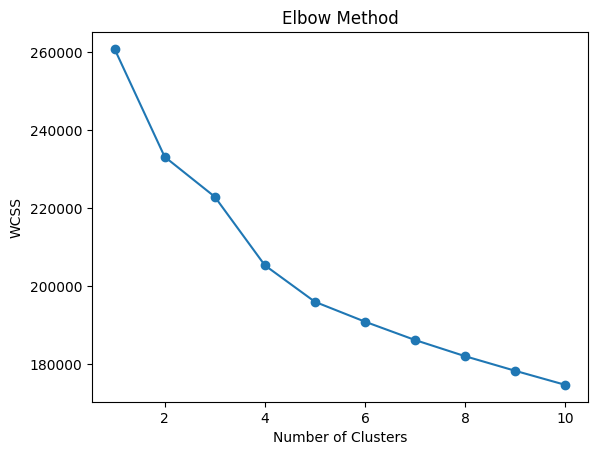

In [11]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()

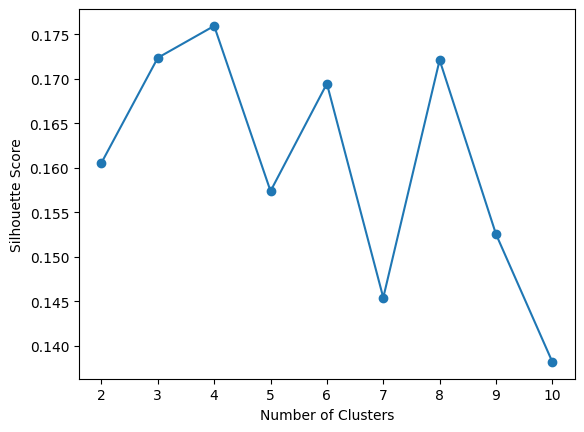

In [12]:
from sklearn.metrics import silhouette_score

scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    scores.append(silhouette_score(X_scaled, labels))

plt.plot(range(2, 11), scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

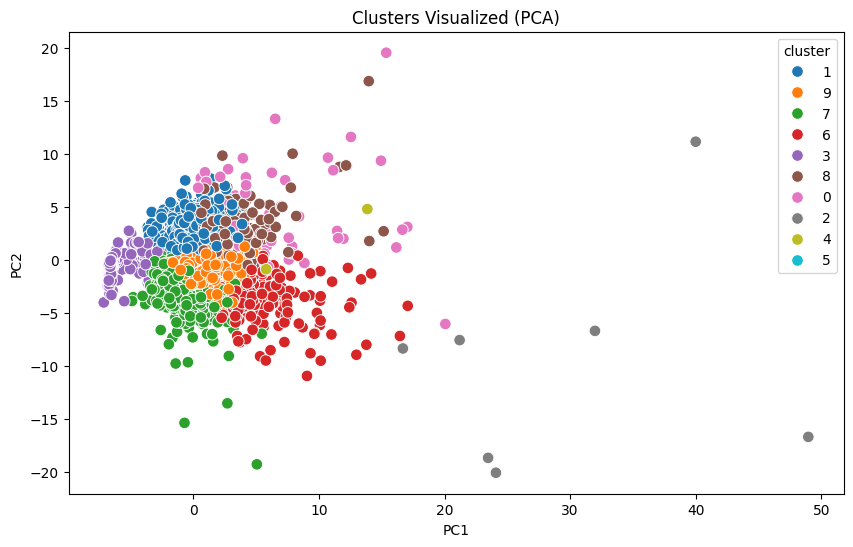

Running t-SNE (this might take a moment)...


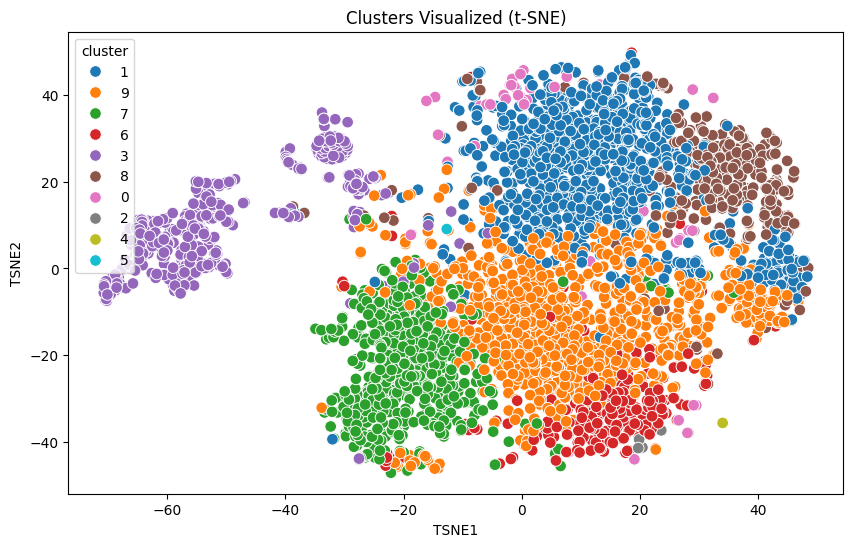

In [13]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 1. PCA Visualization
# PCA reduces the data to 2 dimensions while preserving global variance
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled) 

# Create plotting dataframe
plot_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
plot_df['cluster'] = labels
# Convert to string to ensure discrete coloring
plot_df['cluster'] = plot_df['cluster'].astype(str)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=plot_df, x='PC1', y='PC2', hue='cluster', palette='tab10', s=70)
plt.title('Clusters Visualized (PCA)')
plt.show()

# 2. t-SNE Visualization 
# t-SNE is often better at preserving local clusters in high-dimensional data
print("Running t-SNE (this might take a moment)...")
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

plot_df['TSNE1'] = X_tsne[:, 0]
plot_df['TSNE2'] = X_tsne[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=plot_df, x='TSNE1', y='TSNE2', hue='cluster', palette='tab10', s=70)
plt.title('Clusters Visualized (t-SNE)')
plt.show()

In [15]:
# 1. Isolate the specific cluster you want to analyze (e.g., Cluster 2)
# We convert back to Pandas for easier iteration if preferred, or stay in Polars
target_cluster_id = num = new.get_column("cluster")
sub_group = all_players_with_clusters.filter(pl.col("cluster") == target_cluster_id)

print(f"Sub-clustering {sub_group.height} players from Cluster {target_cluster_id}...")

# 2. Define NEW features specific to this position
# (e.g., If these are Wingers, we care about creativity and dribbling, not tackles)
winger_features = [
    "('Standard', 'Gls')", 
    "('Standard', 'Ast')", 
    "('Possession', 'Succ_Take-Ons')",   # Successful Dribbles
    "('Passing', 'Crs')",                 # Crosses
    "('Shooting', 'Sh')",                 # Shots
    "('Possession', 'Carries_Into_PA')",  # Carries into Penalty Area
    "('Goal_Shot_Creation', 'SCA')"       # Shot Creating Actions
]

# Ensure these columns exist and are normalized per 90 (from your previous steps)
# We assume 'all_player' already has normalized columns
X_sub = sub_group.select(winger_features).to_numpy()

# 3. Scale AGAIN (Crucial because the range of data has changed)
from sklearn.preprocessing import StandardScaler
scaler_sub = StandardScaler()
X_sub_scaled = scaler_sub.fit_transform(X_sub)

# 4. Run K-Means on this sub-group
# Usually a small k (2 or 3) is best here. 
# e.g., 3 sub-types: Creator, Finisher, Ball Carrier
kmeans_sub = KMeans(n_clusters=3, random_state=42)
sub_labels = kmeans_sub.fit_predict(X_sub_scaled)

# 5. Add labels back to the sub_group DataFrame
sub_group = sub_group.with_columns(
    pl.Series(name="sub_cluster", values=sub_labels)
)

# 6. Inspect the results
print(sub_group.select(["player", "team", "sub_cluster"]).sort("sub_cluster"))

Sub-clustering 1683 players from Cluster shape: (1,)
Series: 'cluster' [i32]
[
	0
]...


ColumnNotFoundError: unable to find column "('Standard', 'Gls')"; valid columns: ["league", "team", "player", "('Playing Time', '90s')", "('Performance', 'Gls')", "('Performance', 'Ast')", "('Performance', 'G+A')", "('Performance', 'G-PK')", "('Performance', 'PK')", "('Performance', 'PKatt')", "('Performance', 'CrdY')", "('Performance', 'CrdR')", "('Expected', 'xG')", "('Expected', 'npxG')", "('Expected', 'xAG')", "('Expected', 'npxG+xAG')", "('Progression', 'PrgC')", "('Progression', 'PrgP')", "('Progression', 'PrgR')", "('Touches', 'Touches')", "('Touches', 'Def Pen')", "('Touches', 'Def 3rd')", "('Touches', 'Mid 3rd')", "('Touches', 'Att 3rd')", "('Touches', 'Att Pen')", "('Touches', 'Live')", "('Take-Ons', 'Att')", "('Take-Ons', 'Succ')", "('Take-Ons', 'Succ%')", "('Take-Ons', 'Tkld')", "('Take-Ons', 'Tkld%')", "('Carries', 'Carries')", "('Carries', 'TotDist')", "('Carries', 'PrgDist')", "('Carries', 'PrgC')", "('Carries', '1/3')", "('Carries', 'CPA')", "('Carries', 'Mis')", "('Carries', 'Dis')", "('Receiving', 'Rec')", "('Receiving', 'PrgR')", "('SCA', 'SCA')", "('SCA', 'SCA90')", "('SCA Types', 'PassLive')", "('SCA Types', 'PassDead')", "('SCA Types', 'TO')", "('SCA Types', 'Sh')", "('SCA Types', 'Fld')", "('SCA Types', 'Def')", "('GCA', 'GCA')", "('GCA', 'GCA90')", "('GCA Types', 'PassLive')", "('GCA Types', 'PassDead')", "('GCA Types', 'TO')", "('GCA Types', 'Sh')", "('GCA Types', 'Fld')", "('GCA Types', 'Def')", "('Tackles', 'Tkl')", "('Tackles', 'TklW')", "('Tackles', 'Def 3rd')", "('Tackles', 'Mid 3rd')", "('Tackles', 'Att 3rd')", "('Challenges', 'Tkl')", "('Challenges', 'Att')", "('Challenges', 'Tkl%')", "('Challenges', 'Lost')", "('Blocks', 'Blocks')", "('Blocks', 'Sh')", "('Blocks', 'Pass')", "('Int', '')", "('Tkl+Int', '')", "('Clr', '')", "('Err', '')", "cluster"]